<a href="https://colab.research.google.com/github/etgins/Mice_ASD_Detection/blob/main/final_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----------------------------------------------
Written by Itamar Ginsberg & Alon Schreuer, October 2021


Imports and setup
----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
import os
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV

Data and pre-process
----

In [56]:
# load data from xls/csv file
dataset = pd.read_csv("/content/drive/MyDrive/Project_A/Project_A_files/processed_data_for_final_classification.csv", header=None)
# dataset.info()

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

In [4]:
# pre-process data
  # normalize - different magnitudes between features (!!!)

# print(X.iloc[0,0:5])
scaler = StandardScaler().fit(X)
# print(scaler.mean_)
# print(scaler.var_)
# print(scaler.scale_)
X_scaled = scaler.transform(X)
# X_scaled = pd.DataFrame(data=X_scaled) #TODO - need this?
# print(X_scaled[0,0:5])

In [ ]:
# train-val-test split data (80-10-10)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1)
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=(1/9))


# transform data to DMatrix - a format XGboost can handle well (TODO - relevant?)
# D_train = xgb.DMatrix(X_train, label=y_train)
# D_validation = xgb.DMatrix(X_validation, label=y_validation)
# D_test = xgb.DMatrix(X_test, label=y_test)


XGBoost:
------------
✅ 1. https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101

2. https://towardsdatascience.com/ensemble-learning-and-model-interpretability-a-case-study-95141d75a96c

✅3. https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
- good conceptual explanation of the evolution of decision trees and XGBoost

✅4. https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
- Gradient boosting for decision trees:
  - ensemble method, iteratively creating new trees, each focused on correcting the previous tree's mistakes (each model is trained on the so-far model's errors).


5. https://towardsdatascience.com/a-journey-through-xgboost-milestone-2-f3410109be5a
6. Official XGBoost website: https://xgboost.readthedocs.io/en/latest/parameter.html

✅7. Tune Learning Rate for Gradient Boosting - https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

FULL EXAMPLE FROM SOURCE 1 AS IS
---

Train Accuracy:  1.0
Test Accuracy:  0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.75      0.86      0.80         7

    accuracy                           0.67         9
   macro avg       0.38      0.43      0.40         9
weighted avg       0.58      0.67      0.62         9


Confusion Matrix:
[[0 2]
 [1 6]]


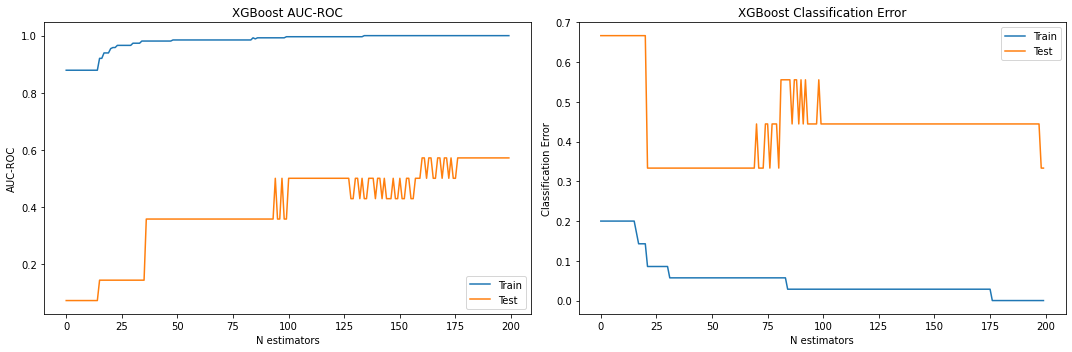

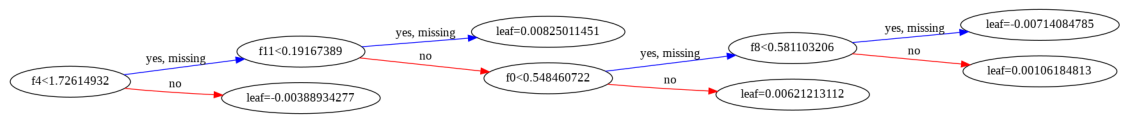

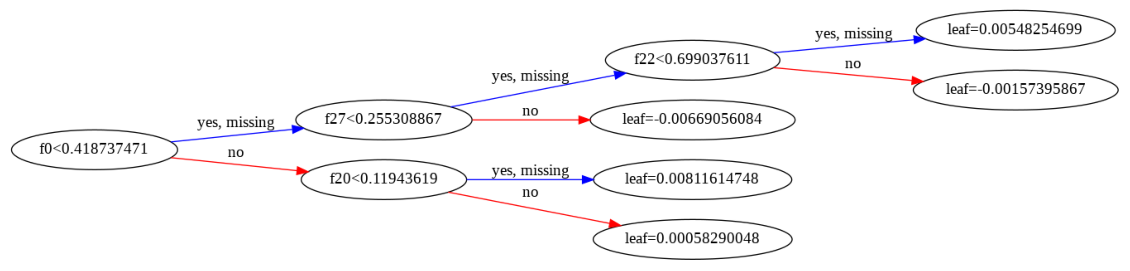

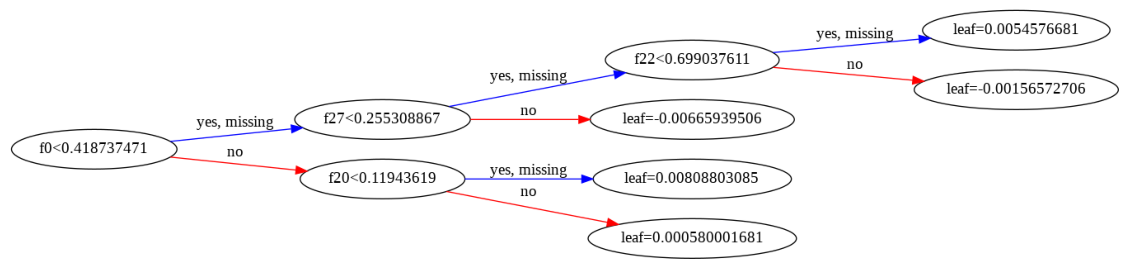

In [124]:
# FULL EXAMPLE FROM SOURCE 1 AS IS
#---------------------------------------------------------
seed = 100
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
# col = pd.Categorical(y)
# y = pd.Series(col.codes)
# validate the preprocessing pipeline by passing data through it

# clean_X = preprocessing_pipeline.fit_transform(X)
# clean_X_df = pd.DataFrame(clean_X, columns=X.columns)
# split the clean_X into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed, shuffle=True)

import time
from xgboost import XGBClassifier
# create a default XGBoost classifier
model = XGBClassifier(n_estimators=200, random_state=seed,learning_rate=0.01, max_depth=4,objective='binary:logistic', booster='gbtree', feval='rmsle')
# define the eval set and metric
# eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_metric = ["auc","error"]
# fit the model
# %time 
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)



from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# final model assessment
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))

pred_test = model.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, pred_test))

print('Classification Report:')
print(classification_report(y_test,pred_test,zero_division=0))



# CHECK ACCURACY BY HAND TO BE SURE:
# print('calculate accuracy by hand - not from example:', '\n')
# accuracy_vec = pred_test == y_test
# print(accuracy_vec)
# num = accuracy_vec.sum()
# print('num = ', num)
# den = len(accuracy_vec)
# print('den = ', den)
# print('by-hand accuracy is:', np.round(accuracy_vec.sum()/len(accuracy_vec)), 3)






# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()


from sklearn.metrics import confusion_matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
#---------------------------------------------------------


plt.rcParams['figure.figsize'] = [20, 10]
xgb.plot_tree(model,num_trees=175, rankdir='LR')
xgb.plot_tree(model,num_trees=176, rankdir='LR')
xgb.plot_tree(model,num_trees=177, rankdir='LR')

# xgb.plot_tree(model, num_trees=20)
# plt.savefig("Tree.png", dpi=100)

***from GridSearch:***

Best model: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}

FULL EXAMPLE FROM SOURCE 1 AS IS - USING GRIDSEARCH
---

In [118]:
# FULL EXAMPLE FROM SOURCE 1 AS IS - USING GRIDSEARCH
#---------------------------------------------------------

# create a default XGBoost classifier
from sklearn.metrics import make_scorer
seed = 1000
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc',
     'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)#, random_state=seed)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix

print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

# store the winning model in a new variable
xgc = best_model.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()
# PLOT FEATURE IMPORTANCE:
# # Create the feature importances plot
# fig, ax = plt.subplots(1, 3, figsize=(15,5))
# # plot importances with feature weight
# xgb.plot_importance(
#     booster=xgc, 
#     importance_type='weight',
#     title='Feature Weight',
#     show_values=False,
#     height=0.5,
#     ax=ax[0],
# )
# # plot importances with split mean gain
# xgb.plot_importance(
#     booster=xgc,
#     importance_type='gain',
#     title='Split Mean Gain',
#     show_values=False,
#     height=0.5,
#     ax=ax[1]
# )
# # plot importances with sample coverage
# xgb.plot_importance(
#     xgc,
#     importance_type='cover',
#     title='Sample Coverage',
#     show_values=False,
#     height=0.5,
#     ax=ax[2]
# )
# plt.tight_layout()
# plt.show()


# TAKEN FROM EXAMPLE WITHOUT GRID SEARCH:
# retrieve performance metrics
results = xgc.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()


# plot a decision tree from the booster
xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()

CPU times: user 3.93 s, sys: 99.6 ms, total: 4.03 s
Wall time: 16 s
Best score: 0.40166666666666656
Best model: {'subsample': 1.0, 'reg_lambda': 1.5, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Train Accuracy:  0.9142857142857143
Test Accuraccy:  0.5555555555555556

Confusion Matrix:
[[0 2]
 [2 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      0.71      0.71         7

    accuracy                           0.56         9
   macro avg       0.36      0.36      0.36         9
weighted avg       0.56      0.56      0.56         9



AttributeError: ignored

FULL EXAMPLE FROM SOURCE 7 AS IS - TUNE LEARNING RATE
---

Best: -0.686385 using {'learning_rate': 0.001, 'n_estimators': 200}
-0.692251 (0.002726) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.691397 (0.005425) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.690585 (0.008098) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.689816 (0.010741) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.689157 (0.013286) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.686626 (0.025487) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.686385 (0.047374) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.691509 (0.066169) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.693973 (0.074653) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.691687 (0.076863) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.698770 (0.097542) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.755335 (0.140180) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.790872 (0.169072) with: {'learning_rate': 0.01, 'n

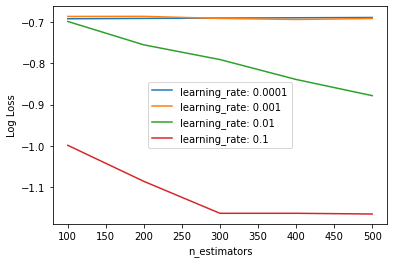

In [67]:
# XGBoost on Otto dataset, Tune learning_rate and n_estimators
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
# load data
# data = read_csv('train.csv')
# dataset = data.values
# # split data into X and y
# X = dataset[:,0:94]
# y = dataset[:,94]
# encode string class values as integers
label_encoded_y = LabelEncoder().fit_transform(y)
# grid search
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_learning_rate.png')

Load Model
--------

In [119]:
# define model hyper-parameters

""" 
from source 4: using sklearn
"""

param = {
    'eta': 0.3, # learning rate - reduce weight of new models, prevent overfitting. Popular values: 0.1-0.3
    'max_depth': 2,  # max_depth of tree
    'objective': 'multi:softprob',  # loss function
    'num_class': 2} # number of classes


steps = 20  # The number of training iterations


# TODO - consider these hyper-parameters as well:
"""
- tree_method: we will use the option “gpu_exact” to run on the GPU
- colsample_bytree: sets the fraction of features (dataset columns) to be randomly used when fitting each individual tree (??)
- reg_lambda: controls L2 regularization
many more...
"""


# TODO - we can create a GRID-SEARCH over hyper-parameters
# (from source 4)
# NOTE: THIS PART INCLUDES THE TRAINING PROCESS OVER THE GRID
#---------------------------------------------------------
# from sklearn.model_selection import GridSearchCV

# clf = xgb.XGBClassifier()
# parameters = {
#      "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
#      }
# grid = GridSearchCV(clf,
#                     parameters, n_jobs=4,
#                     scoring="neg_log_loss",
#                     cv=3)
# grid.fit(X_train, y_train)
#---------------------------------------------------------






""" 
other source?
"""

' \nother source?\n'

Training
--------

In [120]:
""" 
from source 4: using sklearn
"""

# create/load model

seed = 1
model = XGBClassifier(param, n_estimators=500, random_state=seed)
# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

# choose regularization (?)





# TRAINING VER1
#---------------------------------------------------------
# %time 
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)
#---------------------------------------------------------



# TRAINING VER2
#---------------------------------------------------------
# model = xgb.train(param, D_train, steps)
#---------------------------------------------------------


XGBoostError: ignored

In [ ]:
""" 
which source? workframe?
"""



Testing
--------

In [ ]:
""" 
from source 4: using SKlearn
"""

from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

In [ ]:
""" 
from source 1: using SKlearn
"""

# final model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))


In [ ]:
# create a readable description of the model
model.dump_model('dump.raw.txt')



""" 
from source 1: using SKlearn
"""
# retrieve performance metrics + PLOT
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

In [ ]:
# save best model
xgc = best_model_gpu.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()

Under the hood - extra features
------------

In [ ]:
"""
It is possible to specify one of three metrics to calculate the individual feature scores:
Feature Weights: the score is calculated based on the number of times the feature appears in the trees
Gain: the score is calculated based on the average gain of splits which use the feature
Coverage: the score is calculated based on the average coverage (number of samples affected by the split) of splits which use the feature
"""

fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

In [ ]:
# plotting a specific tree

# Create the feature importances plot
fig, ax = plt.subplots(figsize=(20,20))
# plot a decision tree from the booster
xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()